In [1]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh, expm, svd
import quimb as qu


/home/julieta/anaconda3/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/home/julieta/anaconda3/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/home/julieta/anaconda3/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


Objective: Compare methods to study the AKLT hamiltonian 

## Exact diagonalization 

In [2]:
class AKLT_Exact():
    """Handles Hamiltonian construction and basic diagonalization for small N."""
    
    def __init__(self, N, boundary_open=True):
        """
        Initialize AKLT chain with specified boundary conditions.
        
        Args:
            N (int): Number of spins in the chain
            boundary_open (bool): True for open boundaries, False for periodic
        """
        self.N = N
        self.d = 3  # Spin-1 local dimension (3x3 matrices)
        self._initialize_spin_operators()
        self.H = self.Hamiltonian(boundary_open=boundary_open)
        
    def _initialize_spin_operators(self):
        """Initialize spin-1 operators Sx, Sy, Sz with proper normalization."""
        # Spin-1 operators in the z-basis (dimension 3x3)
        self.X = np.sqrt(1/2) * np.array([[0, 1, 0],
                                         [1, 0, 1], 
                                         [0, 1, 0]], dtype=np.complex128)
        
        self.Y = (-1j * np.sqrt(1/2) * np.array([[0, 1, 0],
                                                [-1, 0, 1],
                                                [0, -1, 0]], dtype=np.complex128))
        
        self.Z = np.array([[1, 0, 0],
                          [0, 0, 0],
                          [0, 0, -1]], dtype=np.complex128)

    def construct_chain(self, operator, i, j):
        """
        Embed operators at positions i and j in full N-spin chain.
        
        Args:
            operator: 3x3 matrix (Sx, Sy, or Sz)
            i, j: Positions to place operators (0-based indexing)
            
        Returns:
            3^N x 3^N matrix representing operator acting on sites i and j
        """
        # Initialize chain with identity matrices
        a_chain = [np.eye(self.d, dtype=np.complex128) for _ in range(self.N)]
        
        # Place operators at specified positions
        a_chain[i] = operator
        a_chain[j] = operator
        
        # Build full operator via Kronecker product
        result = a_chain[0]
        for ii in range(1, self.N):
            result = np.kron(result, a_chain[ii])
        return result

    def scalar_product(self, i, boundary_open):
        """
        Compute S_i · S_{i+1} interaction term.
        
        Args:
            i: Site index
            boundary_open: Whether to use open boundary conditions
            
        Returns:
            The interaction term S_i·S_j where j = i+1 (with boundary handling)
        """
        if boundary_open == True:
            j = i + 1
            result = (
                self.construct_chain(self.X, i, j) +
                self.construct_chain(self.Y, i, j) +
                self.construct_chain(self.Z, i, j)
            )
        else: 
            j = (i + 1) % self.N
            result = (
                self.construct_chain(self.X, i, j) +
                self.construct_chain(self.Y, i, j) +
                self.construct_chain(self.Z, i, j)
            )



        return result
    


    def Hamiltonian(self, boundary_open):
        """
        Construct full AKLT Hamiltonian.
        
        Args:
            boundary_open: Boundary condition flag
            
        Returns:
            The Hamiltonian matrix H = Σ_i [S_i·S_{i+1} + (1/3)(S_i·S_{i+1})²]
        """
        H = np.zeros((self.d**self.N, self.d**self.N), dtype=np.complex128)


        if boundary_open ==True:
            for ii in range(self.N - 1):  # Loop over neighboring pairs
                SdotS = self.scalar_product(ii, boundary_open)
                H += SdotS + (1/3)*(SdotS @ SdotS)
        else:

            for ii in range(self.N):  # Loop over neighboring pairs
                SdotS = self.scalar_product(ii, boundary_open)
                H += SdotS + (1/3)*(SdotS @ SdotS)


        return H

    
    
    def ground_and_excited_states(self, ):
        """
        Diagonalize Hamiltonian to get energy spectrum.
        
        Returns:
            eigenvalues: Array of energy eigenvalues
            eigenvectors: Corresponding eigenstates
        """
        eigenvalues, eigenvectors = eigh(self.H)
        return eigenvalues, eigenvectors

    

Open and closed boundary conditions: The AKLT Hamiltonian shows some differences in the energy spectrum due to boundary effects

For open boundary conditions (OBC) we see the ground state is 4 degenerate. Each spin-1 is decomposed into two spin-1/2 particles for OBC the spin-1/2 at the chain ends are unpaired each unpaired spin at the edges can be in $$|\uparrow\rangle$$ or $$|\downarrow\rangle$$ 

For periodic boundary conditions (PBC) the cain has no edges since all spin-1/2 are paired so the ground state is unique

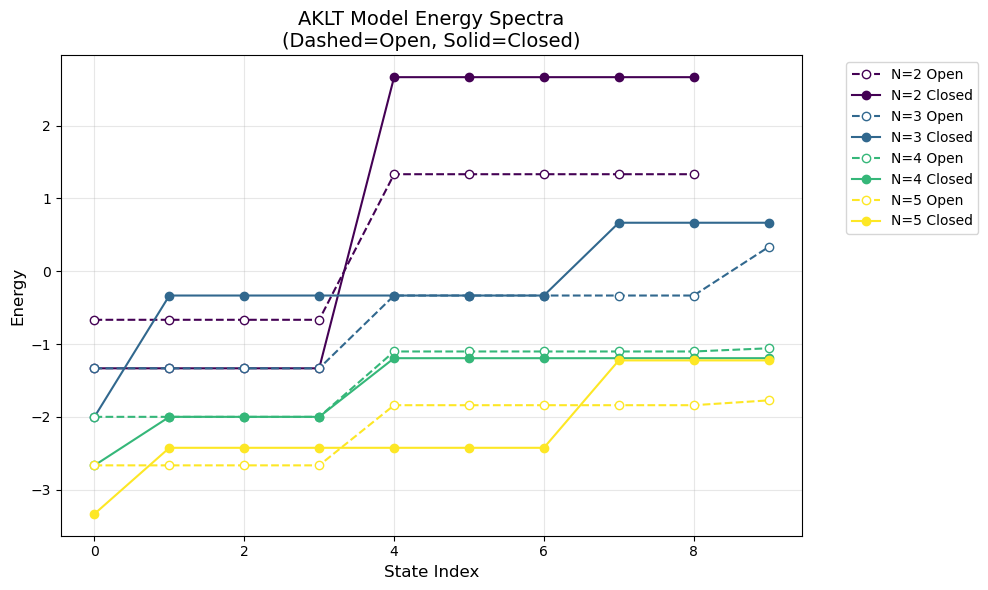

In [3]:
"""Open and closed boundary conditions"""
ns = [2, 3, 4, 5]
colors = plt.cm.viridis(np.linspace(0, 1, len(ns)))  # Color gradient for different N values

plt.figure(figsize=(10, 6))

for i, nn in enumerate(ns):
    # Open boundary (dashed line with circles)
    aklt_open = AKLT_Exact(nn, boundary_open=True)
    eigenvalues_open, _ = aklt_open.ground_and_excited_states()
    plt.plot(eigenvalues_open[:10], '--o', color=colors[i], 
             markersize=6, markeredgecolor=colors[i], markerfacecolor='white',
             label=f'N={nn} Open')
    
    # Closed boundary (solid line with filled circles)
    aklt_closed = AKLT_Exact(nn, boundary_open=False)
    eigenvalues_closed, _ = aklt_closed.ground_and_excited_states()
    plt.plot(eigenvalues_closed[:10], '-o', color=colors[i], 
             markersize=6, markerfacecolor=colors[i],
             label=f'N={nn} Closed')

plt.xlabel('State Index', fontsize=12)
plt.ylabel('Energy', fontsize=12)
plt.title('AKLT Model Energy Spectra\n(Dashed=Open, Solid=Closed)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

